In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, Callback, ReduceLROnPlateau
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import sys
sys.path.append('..')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
! pip install imutils

In [3]:
from imutils import paths

In [4]:
os.chdir('/home/jovyan/Vivian_1070926/Yunzy')

In [5]:
os.getcwd()

'/home/jovyan/Vivian_1070926/Yunzy'

In [6]:
a={'dent':0, 'leeton':1, 'pimple':2, 'residual':3, 'scratch_M':4, 'spot_M':5, 'foreign':6,\
   'longscratch_M':7, 'pinhole':8, 'scratch':9, 'spot':10, 'wrinkle':11}

In [7]:
CLASS_NUM =12

In [8]:
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images("1121aug_12types_100x100/")))
random.seed(42)
random.shuffle(imagePaths)
for sub in imagePaths:
        label = sub.split(os.path.sep)[1] 
        if label[0] == ".":
            continue
        labels.append(a[label])
        image = Image.open(sub)
        try:
            image = image.resize((100, 100))
        except:
            print(image)
        image = img_to_array(image)
        data.append(image)   

In [9]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)        

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data,\
            labels, test_size=0.2, random_state=42)      
(trainX, valX, trainY, valY) = train_test_split(trainX,\
            trainY, test_size=0.25, random_state=42)

In [11]:
trainY = to_categorical(trainY, num_classes=CLASS_NUM)
testnewY = to_categorical(testY, num_classes=CLASS_NUM)
valY = to_categorical(valY, num_classes=CLASS_NUM)


In [12]:
print(trainX.shape, trainY.shape, testX.shape, testnewY.shape)

(12388, 100, 100, 3) (12388, 12) (4130, 100, 100, 3) (4130, 12)


In [13]:
from keras.applications import Xception  #引入能夠架 Xception 的類別
from keras import models
from keras import layers

In [14]:
model_name = 'Xception-15th'

conv_base = Xception(weights="imagenet",include_top=False,input_shape=(100,100,3)) # 架 Xception
model = models.Sequential() # 建一個空的模型
model.add(conv_base) # 把前面架好的 Xception 放進模型
model.add(layers.Flatten()) # 把 Xception 抽取出的圖片特徵攤平
model.add(layers.Dense(256,activation="relu",kernel_initializer='random_normal')) # 再來就是通過幾層 Dense 來做分類
model.add(layers.Dropout(0.3)) # 加 Dropout 避免 overfitting
model.add(layers.Dense(128,activation="relu",kernel_initializer='random_normal'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(12,activation="softmax",kernel_initializer='random_normal'))

In [15]:
datagen = ImageDataGenerator(width_shift_range=0.01,\
                             height_shift_range=0.01,shear_range=0.005,zoom_range=0.005,horizontal_flip=True)

In [16]:
model_path = './model_save_checkpoint/{}.h5'.format(model_name)

lr_reducer = ReduceLROnPlateau(monitor='loss', factor=0.1, cooldown=0, patience=5, min_lr=0.1e-8)
checkpoint = ModelCheckpoint(model_path, monitor='loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='loss', patience=15, verbose=1)

In [17]:
#optimizer = keras.optimizers.Adam(lr=10e-6)
#steps_per_epoch 越大一個epoch越慢跑完
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])
# fits the model on batches with real-time data augmentation: # 用前面建好的 generator 做訓練
model_history = model.fit_generator(datagen.flow(trainX, trainY, batch_size=64), steps_per_epoch=100, epochs = 100,\
                                    validation_data = (valX, valY), callbacks = [earlystop, checkpoint, lr_reducer]) 

Epoch 1/100
100/100 [==============================] - 29s 285ms/step - loss: 0.8192 - acc: 0.7520 - val_loss: 0.6784 - val_acc: 0.8400

Epoch 00001: loss improved from inf to 0.81934, saving model to ./model_save_checkpoint/Xception-15th.h5
Epoch 2/100
100/100 [==============================] - 19s 189ms/step - loss: 0.4196 - acc: 0.8941 - val_loss: 0.4278 - val_acc: 0.9070

Epoch 00002: loss improved from 0.81934 to 0.41957, saving model to ./model_save_checkpoint/Xception-15th.h5
Epoch 3/100
100/100 [==============================] - 19s 192ms/step - loss: 0.2979 - acc: 0.9228 - val_loss: 0.2230 - val_acc: 0.9472

Epoch 00003: loss improved from 0.41957 to 0.29839, saving model to ./model_save_checkpoint/Xception-15th.h5
Epoch 4/100
100/100 [==============================] - 19s 192ms/step - loss: 0.3281 - acc: 0.9261 - val_loss: 1.9452 - val_acc: 0.7758

Epoch 00004: loss did not improve from 0.29839
Epoch 5/100
100/100 [==============================] - 19s 193ms/step - loss: 0.22

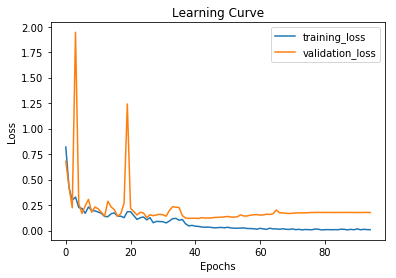

In [18]:
import numpy
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

numpy_loss_history = numpy.array(training_loss)
numpy_loss_valhistory = numpy.array(val_loss)
numpy.savetxt("15th_loss_history.txt", numpy_loss_history, delimiter=",")
numpy.savetxt("15th_val_loss_history.txt", numpy_loss_valhistory , delimiter=",")

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()


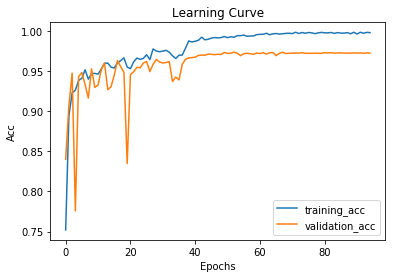

In [19]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

numpy_acc_history = numpy.array(training_acc)
numpy_val_acc_history = numpy.array(val_acc)
numpy.savetxt("15th_acc_history.txt", numpy_acc_history, delimiter=",")
numpy.savetxt("15th_val_acc_history.txt", numpy_val_acc_history , delimiter=",")

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [20]:
model.save("15th.h5")

In [32]:
# os.getcwd()

'/home/jovyan/Vivian_1070926/Yunzy'

In [33]:
# os.chdir('/home/jovyan/Vivian_1070926/Yunzy/model_save')

In [1]:
# from keras.models import load_model
# model = load_model('15th.h5')

In [21]:
scores = model.evaluate(testX, testnewY, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

4130/4130 [==============================] - 4s 996us/step
Validation loss: 0.2170400934839563
Validation accuracy: 0.9673123486682809


from keras.models import load_model
model_history1 = load_model("2nd.h5")

In [22]:
prediction = model.predict_classes(testX)
prediction

array([ 3,  5,  9, ...,  3,  7, 11])

# testY必須是在onehot升維前的數字

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testY, prediction)

array([[267,   5,   2,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  4, 264,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 230,   1,   5,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   8, 234,   4,   1,   0,  24,   0,   0,   0,   4],
       [  0,   0,  13,   7, 249,   0,   0,   3,   0,   0,   0,   0],
       [  1,   0,   0,   1,   0, 265,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0, 274,   0,   0,   0,   0,   0],
       [  0,   0,   4,  19,   5,   0,   0, 421,   0,   0,   0,  11],
       [  0,   0,   0,   0,   0,   0,   0,   0, 259,   0,   0,   0],
       [  0,   3,   0,   0,   0,   0,   0,   0,   0, 273,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 289,   0],
       [  0,   1,   0,   1,   0,   0,   0,   4,   0,   0,   0, 970]])